# Group 7 Wind Power Prediction Code

### By Owen O'Neill, Ailbhe Morrissey, Tim Burke, Nina Woythaler and Sarah Nolan

Hello and welcome to our code. 

To give a brief overview, we're going to begin with an outline of the data processing we did, then go through our process for selecting our models. After that we'll actually run the code you asked for and predict your generation values. Our legacy code/methods we tried that weren't as effective will be in an Appendix at the end (just in case you would like to peruse them).

In any case, let's begin!

First things first, let's import some libraries. We have all the usual suspects here (numpy, pandas, etc.) along with some sklearn packages. 

We experimented extensively with using the Keras library instead of sklearn. The code we wrote is in the Appendix. 
It's rather complex, there are a lot of ways to configure and optimise ANNs with Keras. I haven't commented it because that would take a long time and we were told not to use Keras. I just wanted to show how much work we put in.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import csv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn

from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

Now we'll import all the lovely data :)

We're using pandas to import EVERYTHING into Dataframes. These are very easy to deal with.

We'll concat all of the Dataframes (including power generated, our 'y' values) into one big Dataframe.

Then we get rid of all the NaNs. These are the rows where the x (all of our u100s, v100s, etc.) and y data doesn't line up (the x data starts on the 2nd of January, while the y data starts on the 1st of January. Weird!).

In [2]:
u100 = pd.read_csv('fc_u100.csv', index_col=0, parse_dates=True)
v100 = pd.read_csv('fc_v100.csv', index_col=0, parse_dates=True)
u10 = pd.read_csv('fc_u10.csv', index_col=0, parse_dates=True)
v10 = pd.read_csv('fc_v10.csv', index_col=0, parse_dates=True)
t2m = pd.read_csv('fc_t2m.csv', index_col=0, parse_dates=True)
d2m = pd.read_csv('fc_d2m.csv', index_col=0, parse_dates=True)
msl = pd.read_csv('fc_msl.csv', index_col=0, parse_dates=True)
wp = pd.read_csv('obs_wp.csv', index_col=0, parse_dates=True)

data1 = pd.concat([u100, v100, u10, v10, d2m, t2m, msl, wp], axis=1)
data1 = data1.dropna()

We experimented with adding in other data also. 

Using for loops, we converted u100 and v100 to wind magnitude and wind direction. These didn't seem to give any improvements in score to our networks, so we decided not to do it in our final version.

We also tried converting the wind magnitude to wind power generated, using the Vestas power curve. Again, no visible improvements in score, so we left it out.

Another thing we tried was incorporating time of day and time of year as numerical inputs to our ANN. Surprisingly, this also didn't help with the score, so we didn't pipe it into the ANN. It was still useful for data visualization though, as you'll see below.

The code for how we tried all this is in the Appendix.


Ok, now let's see what data we're working with.

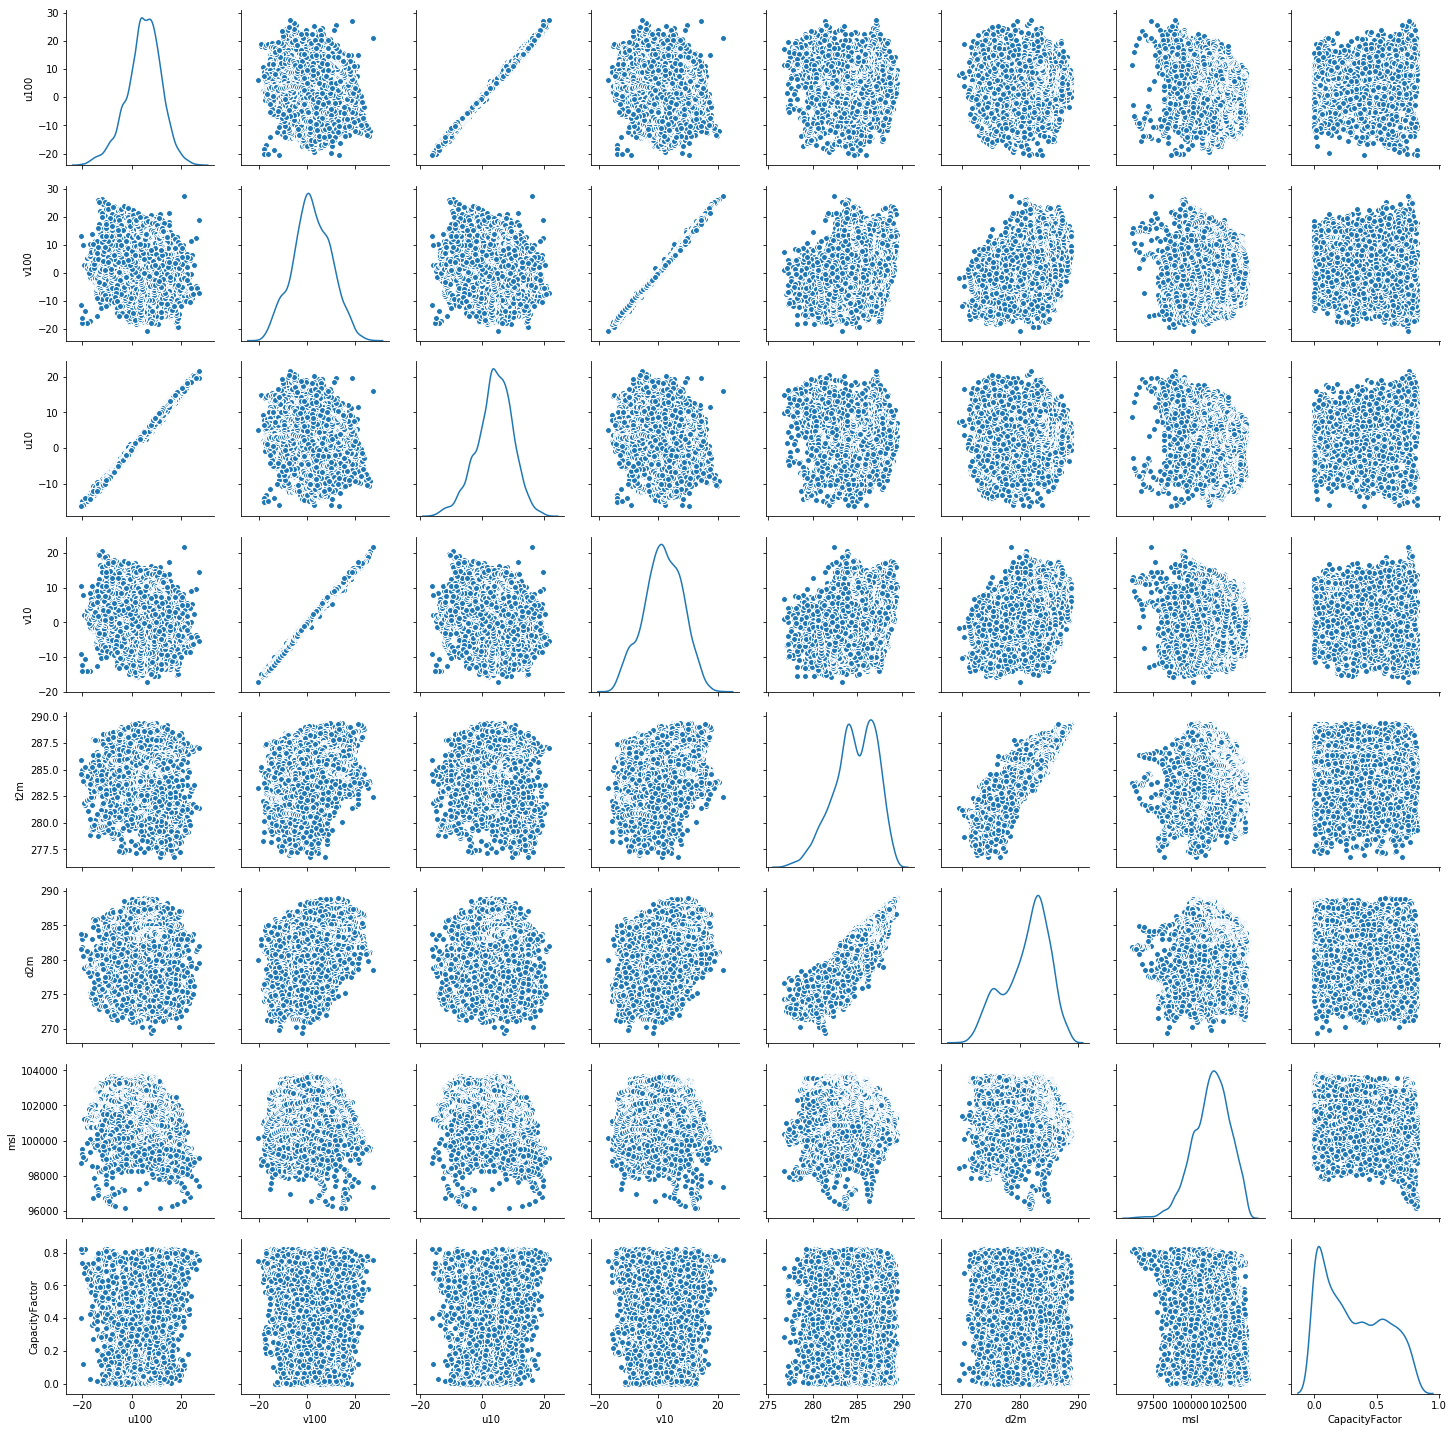

In [3]:
sns.pairplot(data1[["u100", "v100", "u10", "v10", "t2m", "d2m", "msl", "CapacityFactor"]], diag_kind="kde")

Whoa! That's a lot of data visualization! 

What jumps out at us immediately are those straight lines, that shows that there is an almost perfectly linear correlation bewteen u10 and u100 and between v10 and v100. This means we can just drop u10 and v10! That should reduce noise in the model. 

Looks like there is some form of correlation between dewpoint and temperature, but it's not very simple looking.

u100 and v100 have a sort of funnel shape to the data, which makes sense, we would expect a relationship between high wind speeds (in any direction) and high power generated.

msl seems to have a shape to it also, low pressures only generate high amounts of power. Interesting.

I'm not seeing any other patterns jumping out.

We've tried using various combinations of data as well taking into account the shapes we've seen above. We finally came to the decision to just use u100, v100 and msl.

Now that we have our data picked out, we had a look at trying to 'smooth' the data. I tried something called a SavGol filter, which fits the data to a polynomial and pulls in outliers closer to this polynomial approximation. Sounds pretty cool, but surprise surprise, no improvements!

In [4]:
del data1['u10']
del data1['v10']
del data1['d2m']
del data1['t2m']

Ok, now that we have some surface level analysis done, let's deep dive into this. 

I'll start with the importance of cross validation. 

One would think to split the data into train and test sets, fit the data to the train and predict the test data. Then one would find the error of the predictions and go back and adjust the parameters of the model to improve the score. One would end up with excellent scores and one would be led to believe that their model is excellent. When one tries to predict data that the model and you have never seen, however, your scores are less than excellent. Poor, even.

How could one have prevented this from happening? By using some form of validation of course! Instead of splitting into train and test, split data into train, validation and test. Then the model would be fitted to the train and then the validation set would be predicted and used to tune the hyperparameters. When the model is performing reasonably well on the validation, the test could be used to get an accurate estimate of the model's actual quality on unseen data. 

The reason the validation data set is needed is to prevent your knowledge of the test data skewing your results to be better (i.e. overfitting). You won't be able to tune your model to every test data set you need to predict. Your model needs to be robust and able to handle whatever data is thrown at it. 

The issue with using a validation set is that we have less data to train on and to test on. To combat this, we use cross validation. Cross validation splits the entire heap of data into 'k' parts. Then the model will train on 'k-1' parts, then test on the leftover part. The model will cycle through every possible combination of this size, scoring how well it performs on each with a variety of hyperparameters. The model with the best average score is then chosen as the 'best' model.

That sounds fantastic. Really excellent. Just one issue though, we can't use that kind of cross validation here. 

The forecast data is not 'normal' data, it's time series. This means order is very important, the wind at 2am on the 2nd of March is going to be very similar to the wind at 3am on the 2nd of March. So, we don't want to jumble this data by taking random chunks out of the middle. Luckily, there is a way to cross validate with time series. TimeSeriesSplit! This splits the data into k chunks again, but it 'preserves the order'. So the first set will train on the 1st chunk, then validate on the 2nd chunk. The next set will train on the chunk 1 and 2 and validate on the 3rd. This process repeats.

There is a nice visualisation of this process here: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation in section 3.1.2.5.1. Time Series Split.

We were able to get much lower RMSE values by randomising the data, but we were worried that would result in overfitting and the time series data may cause issues.

In any case, we now 'hopefully' have a way of adjusting the hyperparameters without running the risk of overfitting or ignoring the time series aspect.

Ok, that was a mouthful. Those of you who are still awake, please join us we as prep the data.

First we rename the data as X_data and pop out the CapacityFactor column and call it y_data.

Then the X_data is scaled using the StandardScaler. This scales the data column by column so all points are within 1 standard deviation of the mean of that column. This prevents large values (such as pressure) affecting the weights of the ANN too much.

In [5]:
X_data = data1.copy()
y_data = X_data.pop('CapacityFactor')

scaler = StandardScaler()
scaler.fit(X_data)
X_datas = scaler.transform(X_data)

Time to train the model! Here, we are using a grid search along with the TimeSeries cross validation that we were talking about earlier. 

We decided to use 10 splits for cross validation. This struck a balance between time to compute and accuracy.

We define the parameters we would like to try out. These are placed into a dictionary.

We then define the model we want to use; in this case it's an ANN.

Then we define the gridsearch. This takes in the model, parameters, cross validation scheme and a scoring method (MSE) as arguments and creates a grid of all combinations of parameters. The gridsearch will implement the cross validation scheme on all the different combinations of parameters and tell us which one performs best. Great!

After that we just get it to print out the best parameters and the score it got. We can be reasonably confident that this score will be representative of how the model would perform on new, unseen data. 

Unless we've gotten all this wrong. And the model is trash. :)

(No need to run this cell, I've already found the best parameters. This cell takes a long time to run anyways)

In [6]:
# tscv = TimeSeriesSplit(n_splits=10)
# parameters = {"activation": ['relu','tanh'],
#             "solver": ['lbfgs', 'adam'],
#             "alpha": [0.001,0.0001,0.00001],
#             "hidden_layer_sizes": [[4,2],[3,3],[5,5]]}
# mlp = MLPRegressor(max_iter=1200)
# annclf = GridSearchCV(mlp, parameters, cv=tscv, scoring='neg_mean_squared_error')
# annclf.fit(X_datas, np.ravel(y_data))
# annbest_parameters = annclf.best_estimator_.get_params()
# print(annbest_parameters)
# annbest = annclf.best_score_
# print(np.sqrt(abs(annbest)))

{'activation': 'tanh', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': [3, 3], 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1200, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0.19862770672611738


Now that we know what configuration perfoms best, we'll just create an ANN with those parameters and fit it to ALL the data we were given.

In [10]:
ANN = MLPRegressor(activation='tanh', alpha=0.00001, hidden_layer_sizes=[3,3], solver='lbfgs', max_iter=1200)
ANN.fit(X_datas, np.ravel(y_data))

MLPRegressor(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[3, 3], learning_rate='constant',
       learning_rate_init=0.001, max_iter=1200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

***Gradient Boosting Algorithm***

**Why you would use if for predicting wind power?**
Upon researching models to forecast wind power the Gradient Boosting Regression approach seems to be very successful. A model using Gradient Boosting for regression won the Global Energy Forecasting Competition 2014 for probabilistic wind power forecasting.
It also appeared that many of the models adapting the Gradient Boosting approach used input data very similar to that which we used in our model.

**What does gradient boosting do?**
The model basis to any boosting model is to focus on observations which are harder to predict, gradient boosting works in the same way. 
A boosting algorithm uses the weak learning method several times, each one refocused on the observations that the previous ones found difficult to predict or classify.  
The main idea of gradient boosting is to put a larger weight on observations which are difficult to predict than those which appear to be easier to predict.
Using the gradient boosting algorithm, we don’t scale the data and the model preforms better than if we apply it to scaled data. This could be the result of the structure of the model which focuses on harder to predict observations which may be more prominent in the unscaled dataset.

**Parameters**:
The main parameter we need to specify is the loss function which needs to be optimized. We set the loss function to least squares regression as we are using the root mean squared error (RSME) as our measure of model performance. 
We need to be careful that it doesn’t overfit to the training data which it tends to do by naturally as it focuses on observations which are difficult to predict, which could be outliers in our training dataset. As a result, we set a limit to the number of boosting stages to 400. 
In order to decide the value of the ‘learning rate’ and ‘subsample’ parameters we used the Gridsearchcv for optimisation of parameters.

In [8]:
# tscv = TimeSeriesSplit(n_splits=10)
# paragb = {"n_estimators": [300,350,400],
#         "learning_rate":[0.1,0.01,0.001],
#         "subsample": [0.2,0.3,0.4]}
# gradb = GradientBoostingRegressor()
# gbclf = GridSearchCV(gradb, paragb, cv=tscv, scoring='neg_mean_squared_error')
# gbclf.fit(X_data, np.ravel(y_data))
# gbbest_parameters = gbclf.best_estimator_.get_params()
# print(gbbest_parameters)
# gbbest = gbclf.best_score_
# print(np.sqrt(abs(gbbest)))

{'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'presort': 'auto', 'random_state': None, 'subsample': 0.2, 'verbose': 0, 'warm_start': False}
0.19495687587240756


Same as before, we know what configuration for GradientBoost is best, so we'll make a model with those parameters and fit it to ALL the data we were given.

In [9]:
GBR = GradientBoostingRegressor(n_estimators=400, learning_rate=0.01, subsample=0.2)
GBR.fit(X_datas, np.ravel(y_data))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=0.2, verbose=0, warm_start=False)

Ok, that's enough lollygagging, time for some predictions.

Let's import your data. I've copied the layout for our data below, just **update the names of your files.**

This will import, arrange and scale your X data.

In [ ]:
tu100 = pd.read_csv('X.csv', index_col=0, parse_dates=True)
tv100 = pd.read_csv('X.csv', index_col=0, parse_dates=True)
tmsl = pd.read_csv('X.csv', index_col=0, parse_dates=True)
twp = pd.read_csv('X.csv', index_col=0, parse_dates=True)

data2 = pd.concat([tu100, tv100, tmsl, twp], axis=1)
data2 = data2.dropna()

X_tdata = data2.copy()
y_tdata = X_tdata.pop('CapacityFactor')

X_tdatas = scaler.transform(X_tdata)

Now let's predict! 

First up is our ANN. This will predict your data, calculate the errors and graph predicted vs actual values on a nice scatter plot.

In [ ]:
ANNpred = ANN.predict(X_tdatas)
ANNerr = ANNpred - np.ravel(y_tdata)

plt.scatter(y_test, ANNpred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

ANNRMSE = np.sqrt(np.mean(ANNerr**2))
ANNME = np.mean(ANNerr)
print('RMSE =', ANNRMSE)
print('ME =', ANNME)

Hooray!/Ok/Oh No!

Next is GradientBoost. Same story.

In [ ]:
GBRpred = GBR.predict(X_tdatas)
GBRerr = GBRpred - np.ravel(y_tdata)

plt.scatter(y_test, GBRpred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

GBRRMSE = np.sqrt(np.mean(GBRerr**2))
GBRME = np.mean(GBRerr)
print('RMSE =', GBRRMSE)
print('ME =', GBRME)

Hooray!/Ok/Oh No!

And that was all she wrote. I really hope this all worked and we got somewhat decent results. We put a lot of work into this project and we hope this is reflected. If you have any issues or questions, don't hesitate to contact us. Thanks!

# Appendix

In [ ]:
# for i in range(length):
#     data1.iloc[i,2] = np.sqrt((data1.iloc[i,2])**2 + (data1.iloc[i,3])**2)
    
# for i in range(length):
#     data1.iloc[i,2] = np.sqrt((data1.iloc[i,2])**2 + (data1.iloc[i,3])**2)
    
# del data1['v100']

# def vesty(wmag):
#     wmag = round(wmag, 2)
#     p = wmag/0.01
#     p = int(p)
#     y = vestas.loc[p]['Vestas.V80.2000']
#     if y > 40:
#         y = 0
#     return y

# for i in range(length):
#     data1.iloc[i,2] = vesty(data1.iloc[i,2])

In [ ]:
# data1.iloc[:,1] = savgol_filter(data1.iloc[:,1], 51, 3)
# data1.iloc[:,2] = savgol_filter(data1.iloc[:,2], 51, 3)
# data1.iloc[:,3] = savgol_filter(data1.iloc[:,3], 51, 3)

In [ ]:
# month = data1.pop('month')
# data1['jan'] = (month == 1)*1.0
# data1['feb'] = (month == 2)*1.0
# data1['mar'] = (month == 3)*1.0
# data1['apr'] = (month == 4)*1.0
# data1['may'] = (month == 5)*1.0
# data1['jun'] = (month == 6)*1.0
# data1['jul'] = (month == 7)*1.0
# data1['aug'] = (month == 8)*1.0
# data1['sep'] = (month == 9)*1.0
# data1['oct'] = (month == 10)*1.0
# data1['nov'] = (month == 11)*1.0
# data1['dec'] = (month == 12)*1.0

# hour = data1.pop('hour')
# data1['0'] = (hour == 0)*1.0
# data1['1'] = (hour == 1)*1.0
# data1['2'] = (hour == 2)*1.0
# data1['3'] = (hour == 3)*1.0
# data1['4'] = (hour == 4)*1.0
# data1['5'] = (hour == 5)*1.0
# data1['6'] = (hour == 6)*1.0
# data1['7'] = (hour == 7)*1.0
# data1['8'] = (hour == 8)*1.0
# data1['9'] = (hour == 9)*1.0
# data1['10'] = (hour == 10)*1.0
# data1['11'] = (hour == 11)*1.0
# data1['12'] = (hour == 12)*1.0
# data1['13'] = (hour == 13)*1.0
# data1['14'] = (hour == 14)*1.0
# data1['15'] = (hour == 15)*1.0
# data1['16'] = (hour == 16)*1.0
# data1['17'] = (hour == 17)*1.0
# data1['18'] = (hour == 18)*1.0
# data1['19'] = (hour == 19)*1.0
# data1['20'] = (hour == 20)*1.0
# data1['21'] = (hour == 21)*1.0
# data1['22'] = (hour == 22)*1.0
# data1['23'] = (hour == 23)*1.0

In [ ]:
# def build_model():
#     model = keras.Sequential([
#     layers.Dense(100, activation=tf.nn.relu, input_dim=4),

#     layers.Dense(50, activation=tf.nn.relu),

#     layers.Dense(1, activation=tf.nn.sigmoid)
#     ])

#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    
#     model.compile(loss='mean_squared_error',
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error', 'mean_squared_error'])
#     return model

# model = build_model()
# model.fit(X_train_scaled, y_train_scaled, epochs=5, validation_split=0.2,
#                     verbose=1)


# class PrintDot(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 100 == 0: print('')
#         print('.', end='')

# EPOCHS = 500

# history = model.fit(X_train_scaled,
#                     y_train_scaled,
#                     epochs=EPOCHS,
#                     validation_split=0.2,
#                     verbose=0, 
#                     callbacks=[PrintDot()])

# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
 
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error')
#     plt.plot(hist['epoch'], hist['mean_squared_error'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#     plt.ylim([0,1])
#     plt.legend()
#     plt.show()


# plot_history(history)

# baseline_model = keras.Sequential([
#     keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(4,)),
#     keras.layers.Dense(16, activation=tf.nn.relu),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# baseline_model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mean_absolute_error', 'mean_squared_error'])

# baseline_history = baseline_model.fit(X_train_scaled,
#                                       y_train_scaled,
#                                       epochs=20,
#                                       batch_size=512,
#                                       validation_data=(X_test_scaled, y_test_scaled),
#                                       verbose=2)

# smaller_model = keras.Sequential([
#     keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(4,)),
#     keras.layers.Dense(4, activation=tf.nn.relu),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# smaller_model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mean_absolute_error', 'mean_squared_error'])

# smaller_history = smaller_model.fit(X_train_scaled,
#                                       y_train_scaled,
#                                       epochs=20,
#                                       batch_size=512,
#                                       validation_data=(X_test_scaled, y_test_scaled),
#                                       verbose=2)

# bigger_model = keras.models.Sequential([
#     keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(4,)),
#     keras.layers.Dense(512, activation=tf.nn.relu),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# bigger_model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mean_absolute_error', 'mean_squared_error'])

# bigger_history = bigger_model.fit(X_train_scaled,
#                                       y_train_scaled,
#                                       epochs=20,
#                                       batch_size=512,
#                                       validation_data=(X_test_scaled, y_test_scaled),
#                                       verbose=2)

# def plot_history(histories, key='mean_squared_error'):
#     plt.figure(figsize=(16,10))
    
#     for name, history in histories:
#         val = plt.plot(history.epoch, history.history['val_'+key],
#                    '--', label=name.title()+' Val')
#         plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
#              label=name.title()+' Train')

#     plt.xlabel('Epochs')
#     plt.ylabel(key.replace('_',' ').title())
#     plt.legend()

#     plt.xlim([0,max(history.epoch)])


# plot_history([('baseline', baseline_history),
#               ('smaller', smaller_history),
#               ('bigger', bigger_history)])

# dpt_model = keras.models.Sequential([
#     keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(4,)),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(16, activation=tf.nn.relu),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# dpt_model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mean_absolute_error', 'mean_squared_error'])

# dpt_model_history = dpt_model.fit(X_train_scaled,
#                                       y_train_scaled,
#                                       epochs=20,
#                                       batch_size=512,
#                                       validation_data=(X_test_scaled, y_test_scaled),
#                                       verbose=2)

# plot_history([('baseline', baseline_history),
#               ('dropout', dpt_model_history)])

# l2_model = keras.models.Sequential([
#     keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                        activation=tf.nn.relu, input_shape=(4,)),
#     keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                        activation=tf.nn.relu),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# l2_model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mean_absolute_error', 'mean_squared_error'])

# l2_model_history = l2_model.fit(X_train_scaled,
#                                       y_train_scaled,
#                                       epochs=20,
#                                       batch_size=512,
#                                       validation_data=(X_test_scaled, y_test_scaled),
#                                       verbose=2)

# plot_history([('baseline', baseline_history),
#               ('l2', l2_model_history)])